### Trying to Implement resnet from scratch
[Refernces](https://github.com/hellowangqian/multi-label-image-classification/blob/master/VOC2007/myresnet_fc.py)
![](https://miro.medium.com/max/1225/1*aq0q7gCvuNUqnMHh4cpnIw.png)

In [1]:
import torch
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo

import torchsummary
from torchsummary import summary

from torchviz import make_dot
from torchvision import models

In [2]:
__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152']
model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}

### Basic 3x3 convolution
![](http://www.ashokrahulgade.com/skills/DL/CNN/2.gif)

In [3]:
def conv3x3(in_planes, out_planes, stride=1):
    """
    Basic 3x3 convolution with padding
    :param in_planes: number of planes/channels of input
    :param out_planes: number of planes/channels of output
    :param stride: stride
    :return basic 3x3 convolution with padding
    """
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)

In [4]:
# example
in_planes = 3
imput_side = (5, 5)
input_ = torch.rand(tuple([1, in_planes] + list(imput_side)))
input_

tensor([[[[0.0690, 0.9623, 0.6714, 0.8870, 0.1808],
          [0.0589, 0.1089, 0.1801, 0.3705, 0.9606],
          [0.2433, 0.5181, 0.8662, 0.1238, 0.2630],
          [0.0116, 0.9891, 0.8509, 0.6181, 0.8114],
          [0.2622, 0.9459, 0.4169, 0.3452, 0.3043]],

         [[0.8343, 0.9869, 0.0271, 0.3845, 0.3048],
          [0.5512, 0.3381, 0.6613, 0.6079, 0.2096],
          [0.8977, 0.1232, 0.9174, 0.8271, 0.4942],
          [0.5426, 0.2869, 0.4411, 0.6314, 0.3466],
          [0.5637, 0.7448, 0.4806, 0.2538, 0.9787]],

         [[0.9640, 0.4404, 0.3435, 0.7696, 0.8418],
          [0.6512, 0.4924, 0.4049, 0.0583, 0.3039],
          [0.9377, 0.3268, 0.1622, 0.4500, 0.5366],
          [0.6230, 0.6702, 0.0191, 0.4328, 0.1132],
          [0.4503, 0.8484, 0.1085, 0.5490, 0.3553]]]])

In [5]:
out_planes = 2
output=conv3x3(in_planes, out_planes)(input_)
output

tensor([[[[ 0.3828,  0.0564,  0.2506,  0.0036,  0.2468],
          [ 0.1779, -0.1323,  0.2829,  0.0018,  0.2349],
          [ 0.0675,  0.1180, -0.0944,  0.2813,  0.1216],
          [-0.0949,  0.3519, -0.1407,  0.1554,  0.2248],
          [ 0.3447,  0.4611,  0.2218,  0.2922,  0.1343]],

         [[ 0.3601,  0.0195,  0.0882,  0.1917, -0.0366],
          [ 0.3812,  0.3402,  0.1780,  0.0519, -0.1035],
          [ 0.2627,  0.2101,  0.2441,  0.0493,  0.0669],
          [ 0.3168,  0.2526,  0.2999,  0.0885,  0.0909],
          [ 0.3082,  0.1346, -0.1077,  0.1572, -0.0383]]]],
       grad_fn=<MkldnnConvolutionBackward>)

In [6]:
print('Input shape:', input_.shape)
print('Output shape:', output.shape)
# as if we convert one RGB image size 5x5 to 2-channel size 5x5

Input shape: torch.Size([1, 3, 5, 5])
Output shape: torch.Size([1, 2, 5, 5])


### Resnet basic block
![](https://miro.medium.com/max/998/1*D0F3UitQ2l5Q0Ak-tjEdJg.png)
As showed in the above figure, the dimensions of output and residual have to be the same, if not we have to down-sample input x

In [7]:
class BasicBlock(nn.Module):
    expansion = 1  # No expansion is used with Basic Block

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        """
        Initialise basic block without expansion
        :param inplanes: input planes
        :param planes: output planes
        :param downsample: a convolution layer to change the dimension of input into dimension of output for 
        addition operation
        """
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        """Forward pass"""
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        
        # match the dimension
        if self.downsample is not None:
            residual = self.downsample(x)  

        out += residual
        out = self.relu(out)

        return out

In [8]:
bblock = BasicBlock(inplanes=3, planes=3)

In [9]:
input_ = torch.rand(1, 3, 5, 5)
output = bblock(input_)
print(input_)
print(output)

tensor([[[[0.6135, 0.2437, 0.2197, 0.9129, 0.7667],
          [0.8667, 0.5726, 0.4446, 0.7065, 0.9165],
          [0.9287, 0.0046, 0.1224, 0.7306, 0.2407],
          [0.0488, 0.8773, 0.3110, 0.5536, 0.7110],
          [0.2860, 0.8630, 0.2651, 0.5231, 0.1570]],

         [[0.3728, 0.3212, 0.4918, 0.5217, 0.6862],
          [0.9749, 0.1443, 0.7343, 0.2108, 0.4892],
          [0.2607, 0.5726, 0.5900, 0.9494, 0.9478],
          [0.8770, 0.4587, 0.5207, 0.9348, 0.3449],
          [0.8818, 0.7053, 0.9292, 0.4417, 0.5854]],

         [[0.2004, 0.5595, 0.7999, 0.7624, 0.9113],
          [0.2123, 0.2607, 0.1135, 0.5163, 0.0708],
          [0.9009, 0.6409, 0.1062, 0.2651, 0.5237],
          [0.3187, 0.2566, 0.0475, 0.0824, 0.9283],
          [0.1923, 0.9573, 0.2304, 0.7945, 0.9351]]]])
tensor([[[[1.3714e+00, 3.1025e-01, 8.4786e-01, 5.7016e-01, 8.5580e-01],
          [0.0000e+00, 0.0000e+00, 1.9652e-01, 1.0519e+00, 9.5938e-01],
          [8.4174e-01, 7.2360e-01, 0.0000e+00, 7.3240e-01, 1.3227e-01

In [10]:
print('Input shape:', input_.shape)
print('Output shape:', output.shape)

Input shape: torch.Size([1, 3, 5, 5])
Output shape: torch.Size([1, 3, 5, 5])


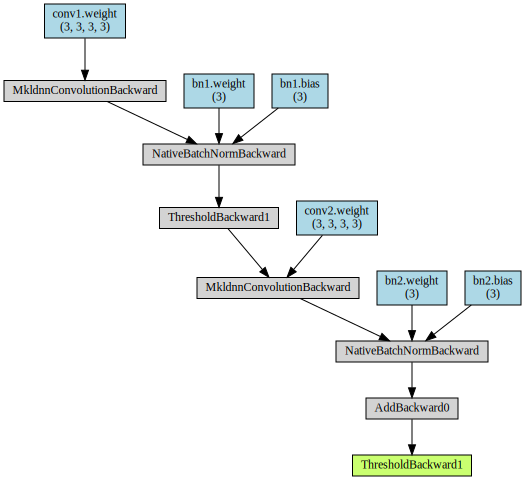

In [11]:
make_dot(output, params=dict(bblock.named_parameters()))

In [12]:
summary(bblock.to('cuda'), (3,5,5))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1              [-1, 3, 5, 5]              81
       BatchNorm2d-2              [-1, 3, 5, 5]               6
              ReLU-3              [-1, 3, 5, 5]               0
            Conv2d-4              [-1, 3, 5, 5]              81
       BatchNorm2d-5              [-1, 3, 5, 5]               6
              ReLU-6              [-1, 3, 5, 5]               0
Total params: 174
Trainable params: 174
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


### BottleNeck 
![](https://www.researchgate.net/profile/Antonio_Theophilo/publication/321347448/figure/fig2/AS:565869411815424@1511925189281/Bottleneck-Blocks-for-ResNet-50-left-identity-shortcut-right-projection-shortcut.png)
Bottleneck Blocks for ResNet-50 (left: identity shortcut; right: projection shortcut). 

As showed in the figure, we have to up-sample input to support adding operation


In [13]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        """
        Initialise bottle neck block
        :param inplanes: input planes
        :param planes: planes after 1-st and 2-nd convolution
        :param downsample: a convolution layer to change dimension of input (inplanes * size1 * size2)
        to dimension after 3 convolutions layers ([expansion*planes] * size1' * size2')
        """
        super(Bottleneck, self).__init__()
        
        # inplanes >>> planes 
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)  
        self.bn1 = nn.BatchNorm2d(planes)
        
        # planes >>> planes
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        
        # planes >>> planes * expansion
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)
      
        if self.downsample is not None:
            residual = self.downsample(x)  
        # As in right image, change input dimension to dimension of output after convolution
        # otherwise addition below is impossible
    
        out += residual
        out = self.relu(out)

        return out

In [14]:
inplanes = 3
planes = 5
expansion = 4
stride = 1

downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * expansion)
            )

bneck = Bottleneck(inplanes, planes, downsample=downsample)

In [15]:
summary(bneck.to('cuda'), input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 5, 64, 64]              15
       BatchNorm2d-2            [-1, 5, 64, 64]              10
              ReLU-3            [-1, 5, 64, 64]               0
            Conv2d-4            [-1, 5, 64, 64]             225
       BatchNorm2d-5            [-1, 5, 64, 64]              10
              ReLU-6            [-1, 5, 64, 64]               0
            Conv2d-7           [-1, 20, 64, 64]             100
       BatchNorm2d-8           [-1, 20, 64, 64]              40
            Conv2d-9           [-1, 20, 64, 64]              60
      BatchNorm2d-10           [-1, 20, 64, 64]              40
             ReLU-11           [-1, 20, 64, 64]               0
Total params: 500
Trainable params: 500
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward

In [16]:
input_ = torch.rand(1,3,64,64).to('cuda')
output = bneck(input_.to('cuda'))
print('Input shape:', input_.shape)
print('Output shape:', output.shape)

Input shape: torch.Size([1, 3, 64, 64])
Output shape: torch.Size([1, 20, 64, 64])


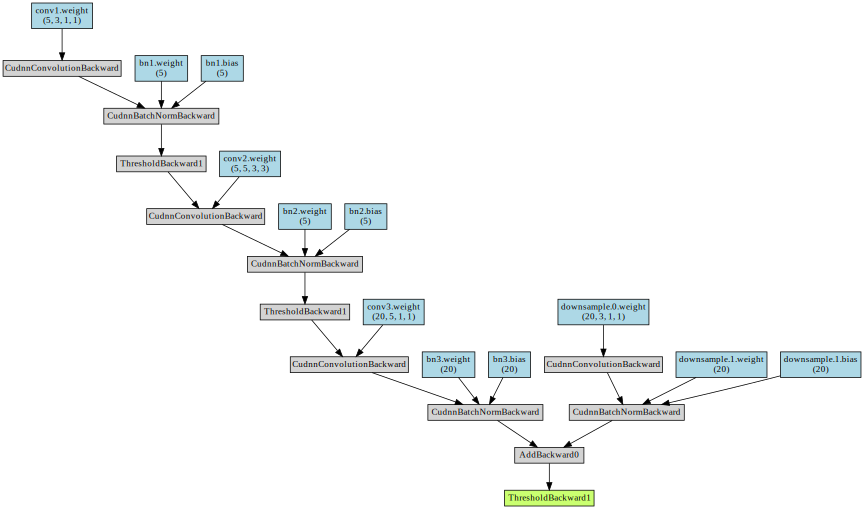

In [17]:
make_dot(output, params=dict(bneck.named_parameters()))

### ResNet general architecture
- basic block/bottle neck stay on top of each other
- the size decreases (with stride>2 in convolution) while depth increase (planes * expansion > inplanes)

In [18]:
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=20):
        """
        Initilise residual network
        :param block: BasicBlock/BottleNeck
        :param layers: number of times to repeat a layer
        :param num_classes: output dimension
        """
        
        # 3 = original planes of an RGB image
        # 64 = number of planes/filter befor residual blocks
        # Generally, input size of images for resnet is 224x224 with 3 channels (R-G-B)
        self.inplanes = 64
        super(ResNet, self).__init__()
        
        # Very first down-sample layers 
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # Residual blocks
        
        # Repeat block with output planes/filters (=block.expansion * 64) layers[0] times
        self.layer1 = self._make_layer(block, 64, layers[0])
        # Repeat block with output planes/filters (=block.expansion * 128) layers[1] times
        # the size decrease 2 times as stride = 2
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        
        # Initialize parameters
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        """
        Make layers from `block` with `planes` and repeat `blocks` times 
        """
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion)
            )
        layers = []
        # Add downsample to first use of block because inplanes and outplanes (=block.expansion*planes)
        # here are not the same
        layers.append(block(self.inplanes, planes, stride, downsample))
        
        # After applying block, the planes changed to planes * block.expansion
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            # Here the planes decrease from planes * block.expansion to planes 
            # then expand to planes * block.expansion
            layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0),-1)
        x = self.fc(x)
        return x

### Resnet 18
![](https://www.researchgate.net/profile/Muhammad_Hasan19/publication/323063171/figure/fig1/AS:603178554904576@1520820382219/Proposed-Modified-ResNet-18-architecture-for-Bangla-HCR-In-the-diagram-conv-stands-for.png)

- layer 1: use basic block, planes = 64, repeat 2 times
- layer 2: use basic block, planes = 128, repeat 2 times
- layer 3: use basic block, planes = 256, repeat 2 times
- layer 4: use basic block, planes = 512, repeat 2 times
- no expansion

In [24]:
resnet_18 = ResNet(BasicBlock, [2, 2, 2, 2], 1000)

In [25]:
dict(resnet_18.named_children()).keys()

dict_keys(['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool', 'fc'])

In [26]:
# First normal layers
print("Convolution:", resnet_18.conv1)
print("Batch normalization:", resnet_18.bn1)
print("Activation, ReLu:", resnet_18.relu)
print("Pooling, max:", resnet_18.maxpool)

Convolution: Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Batch normalization: BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Activation, ReLu: ReLU(inplace)
Pooling, max: MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)


In [27]:
# First residual block
# This block contains two sub-block (= Basic Block), the number of planes for each is 64
print(resnet_18.layer1)

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)


In [28]:
# Second residual block
# This block contains two sub-block (= Basic Block), 
# the number of planes for first block are 64 >> 128, for the second 128 >> 128
# the size decreases 2 times as stride = 2
print(resnet_18.layer2)

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, moment

In [29]:
# Third residual block
# This block contains two sub-block (= Basic Block), 
# the number of planes for first block are 128 >> 256, for the second 256 >> 256
# the size decreases 2 times as stride = 2
print(resnet_18.layer3)

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(256, eps=1e-05, mome

In [30]:
# Fourth residual block
# This block contains two sub-block (= Basic Block), 
# the number of planes for first block are 256 >> 512, for the second 512 >> 512
# the size decreases 2 times as stride = 2
print(resnet_18.layer4)

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, mome

In [31]:
# Global average pooling layer
print(resnet_18.avgpool)

AdaptiveAvgPool2d(output_size=(1, 1))


In [32]:
# Classifier/fully-connected layer
print(resnet_18.fc)

Linear(in_features=512, out_features=1000, bias=True)


In [33]:
# the model summary
summary(resnet_18.to('cuda'), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [34]:
input_ = torch.rand(1, 3, 224, 224).to('cuda')
output = resnet_18(input_)
print(input_.shape)
print(output.shape)

torch.Size([1, 3, 224, 224])
torch.Size([1, 1000])


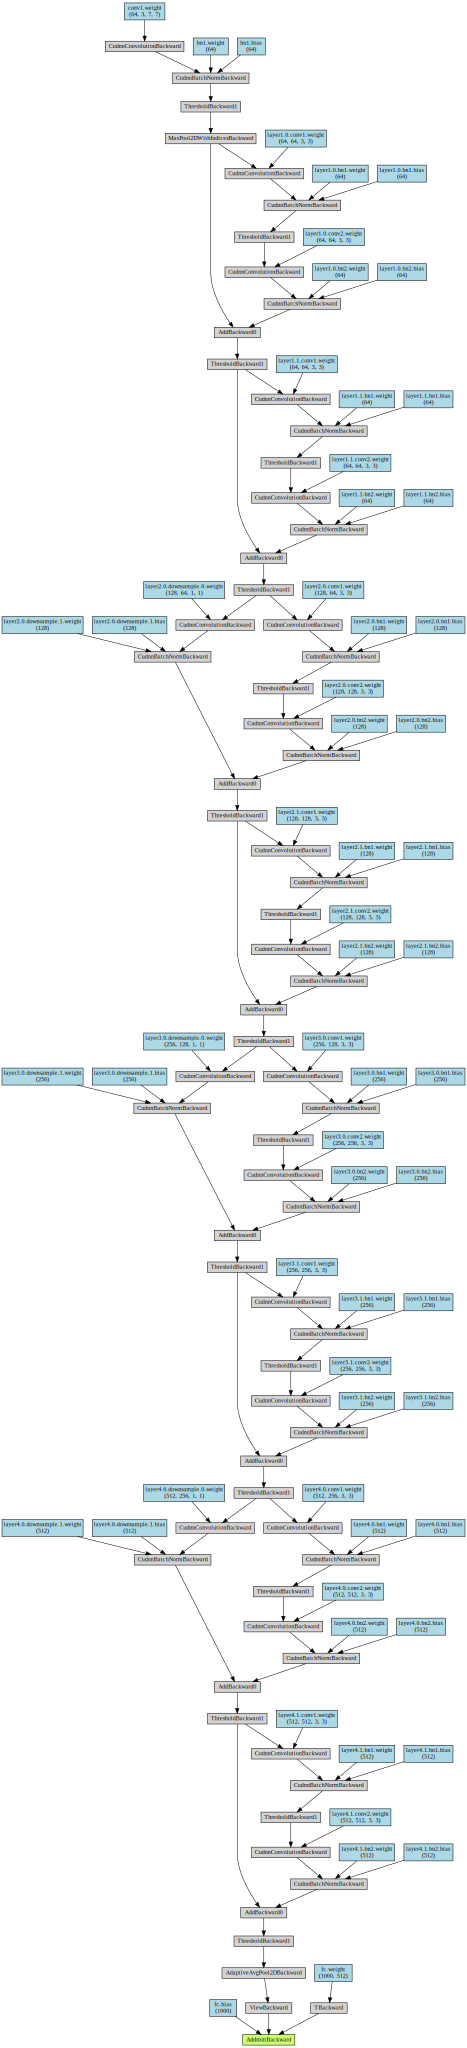

In [35]:
make_dot(output, params=dict(resnet_18.named_parameters()))

In [36]:
# load pre-trained model with 1000 classes
with torch.no_grad():
    resnet_18.load_state_dict(model_zoo.load_url(model_urls['resnet18']))

### Pretrained resnet18

In [37]:
resnet18 = models.resnet18(pretrained=True)
dict(resnet18.named_children()).keys()

dict_keys(['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool', 'fc'])

In [38]:
print(resnet18.conv1, resnet18.bn1, resnet18.relu, resnet18.maxpool, sep='\n')

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU(inplace)
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)


In [39]:
resnet18.layer1

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [40]:
resnet18.layer2

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, moment

In [41]:
resnet18.layer3

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(256, eps=1e-05, mome

In [42]:
resnet18.layer4

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, mome

In [43]:
print(resnet18.avgpool, resnet18.fc, sep='\n')

AdaptiveAvgPool2d(output_size=(1, 1))
Linear(in_features=512, out_features=1000, bias=True)


In [46]:
summary(resnet18.to('cuda'), (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [47]:
input_ = torch.rand(1, 3, 224, 224).to('cuda')
output = resnet18.to('cuda')(input_)
print(input_.shape)
print(output.shape)

torch.Size([1, 3, 224, 224])
torch.Size([1, 1000])


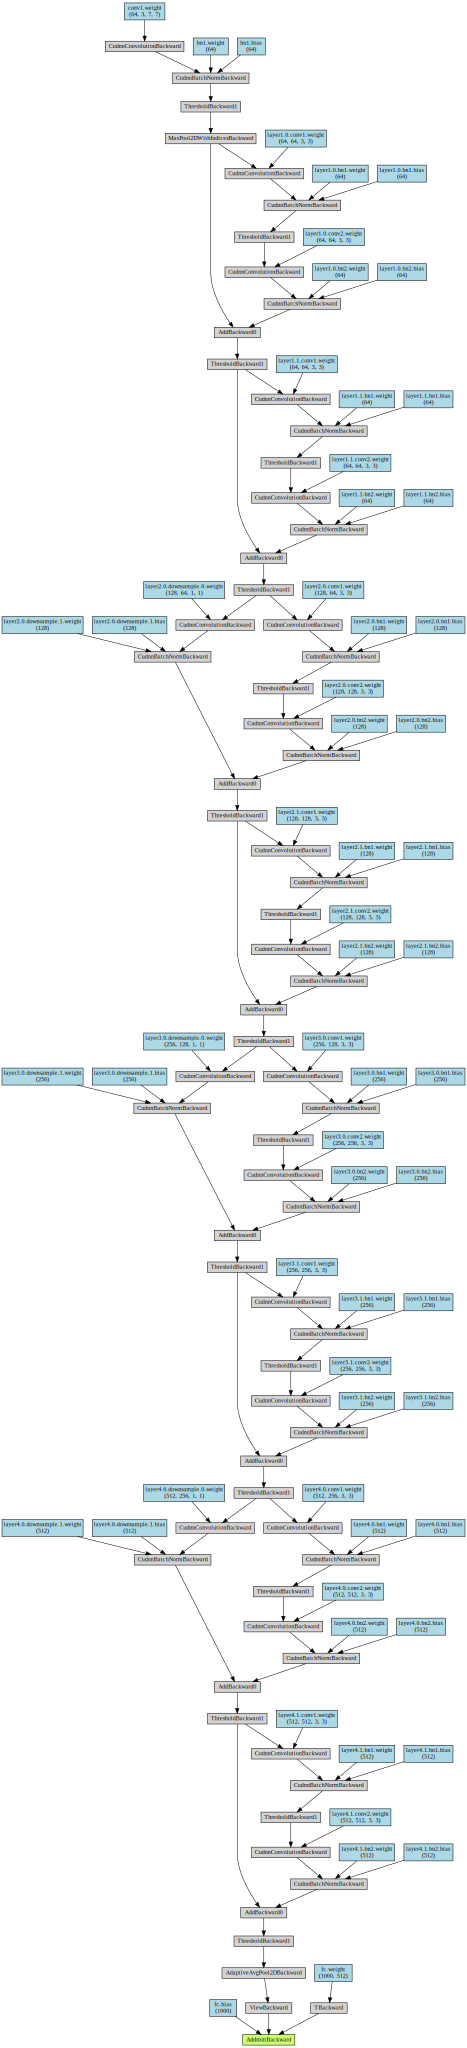

In [48]:
make_dot(var=output, params=dict(resnet18.named_parameters()))

### ResNet 34
![](https://miro.medium.com/max/1225/1*S3TlG0XpQZSIpoDIUCQ0RQ.jpeg)
- layer 1: use basic block, planes = 64, repeat 3 times
- layer 2: use basic block, planes = 128, repeat 4 times
- layer 3: use basic block, planes = 256, repeat 6 times
- layer 4: use basic block, planes = 512, repeat 3 times
- no expansion

In [49]:
resnet_34 = ResNet(BasicBlock, [3, 4, 6, 3], 1000)
dict(resnet_34.named_children()).keys()

dict_keys(['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool', 'fc'])

In [50]:
resnet_34.layer1
# sequence of 3 BasicBlock 

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (2): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, 

In [51]:
resnet_34.layer2
# sequence of 4 BasicBlock 

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, moment

In [52]:
resnet_34.layer3
# sequence of 6 BasicBlock 

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(256, eps=1e-05, mome

In [53]:
resnet_34.layer4
# sequence of 3 BasicBlock 

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, mome

In [54]:
with torch.no_grad():
    resnet_34.load_state_dict(model_zoo.load_url(model_urls['resnet34']))

In [55]:
summary(resnet_34.to('cuda'), (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [56]:
input_ = torch.rand(1, 3, 224, 224).to('cuda')
output = resnet_34(input_)
print(input_.shape, ">>>", output.shape)

torch.Size([1, 3, 224, 224]) >>> torch.Size([1, 1000])


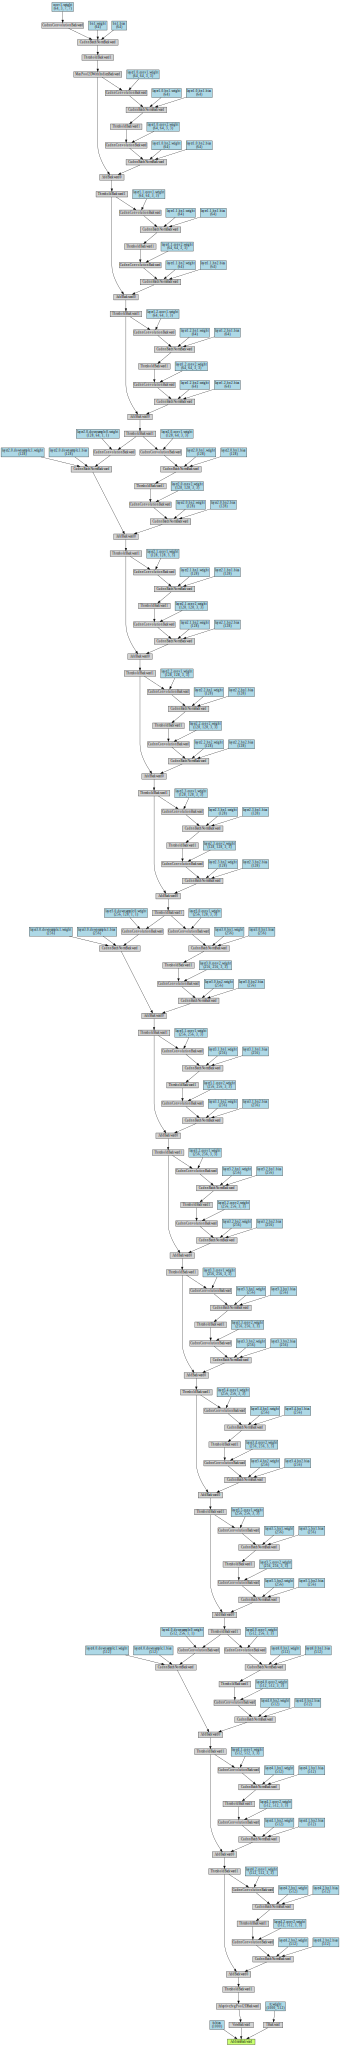

In [57]:
make_dot(output, dict(resnet_34.named_parameters()))

### ResNet 50
![](https://www.codeproject.com/KB/AI/1248963/resnet.png)
- layer 1: use BottleNeck block, planes = 64, repeat 3 times
- layer 2: use BottleNeck block, planes = 128, repeat 4 times
- layer 3: use BottleNeck block, planes = 256, repeat 6 times
- layer 4: use BottleNeck block, planes = 512, repeat 3 times
- expansion = 4

In [59]:
resnet_50 = ResNet(Bottleneck, [3, 4, 6, 3], 1000)
with torch.no_grad():
    resnet_50.load_state_dict(model_zoo.load_url(model_urls['resnet50']))
dict(resnet_50.named_children()).keys()

dict_keys(['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool', 'fc'])

In [60]:
resnet_50.layer1
# 3 bottle-neck blocks, expansion 64 >> 256

Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): Bottleneck(
    (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_

In [61]:
resnet_50.layer2
#4 bottle-neck blocks, expansion 128 >> 512

Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (downsample): Sequential(
      (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): Bottleneck(
    (conv1): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(128, 

In [62]:
resnet_50.layer3
# 6 bottle-neck blocks, expansion 256 >> 1024

Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (downsample): Sequential(
      (0): Conv2d(512, 1024, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): Bottleneck(
    (conv1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(

In [63]:
resnet_50.layer4
# 3 bottle-neck blocks, expansion 512 >> 2048

Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (downsample): Sequential(
      (0): Conv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): Bottleneck(
    (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2

In [64]:
summary(resnet_50.to('cuda'), (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [65]:
input_ = torch.rand(1, 3, 224, 224).to('cuda')
output = resnet_50.to('cuda')(input_)
print(input_.shape, '>>>', output.shape)

torch.Size([1, 3, 224, 224]) >>> torch.Size([1, 1000])


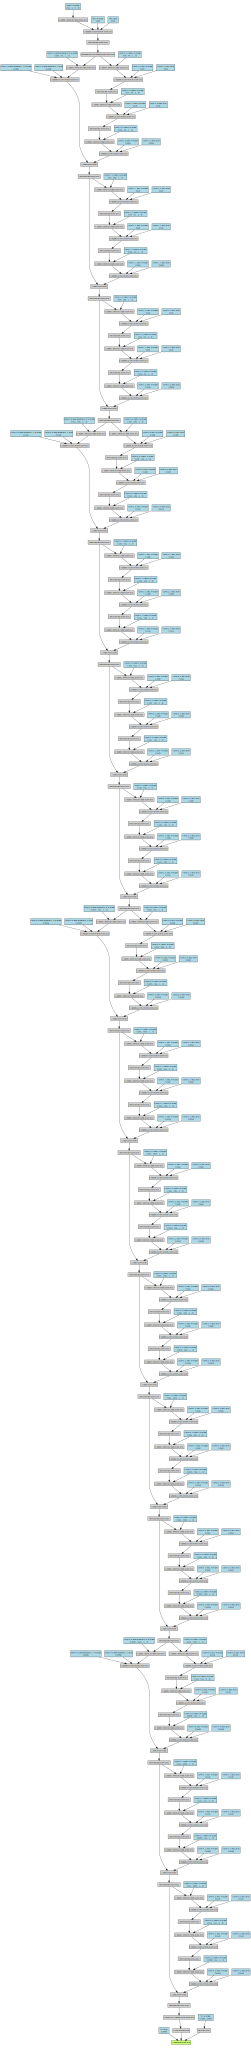

In [66]:
make_dot(output, dict(resnet_50.named_parameters()))

In [68]:
# dict_keys(['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool', 'fc'])
features = nn.Sequential(
    resnet_50.conv1,
    resnet_50.bn1,
    resnet_50.relu,
    resnet_50.maxpool,
    resnet_50.layer1,
    resnet_50.layer2,
    resnet_50.layer3,
    resnet_50.layer4
)

In [69]:
print(input_.shape, '>>>', features(input_).shape)

torch.Size([1, 3, 224, 224]) >>> torch.Size([1, 2048, 7, 7])


In [72]:
resnet101 = ResNet(Bottleneck, [3, 4, 23, 3], 1000)
with torch.no_grad():
    resnet101.load_state_dict(model_zoo.load_url(model_urls['resnet101']))
summary(resnet101.to('cuda'), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

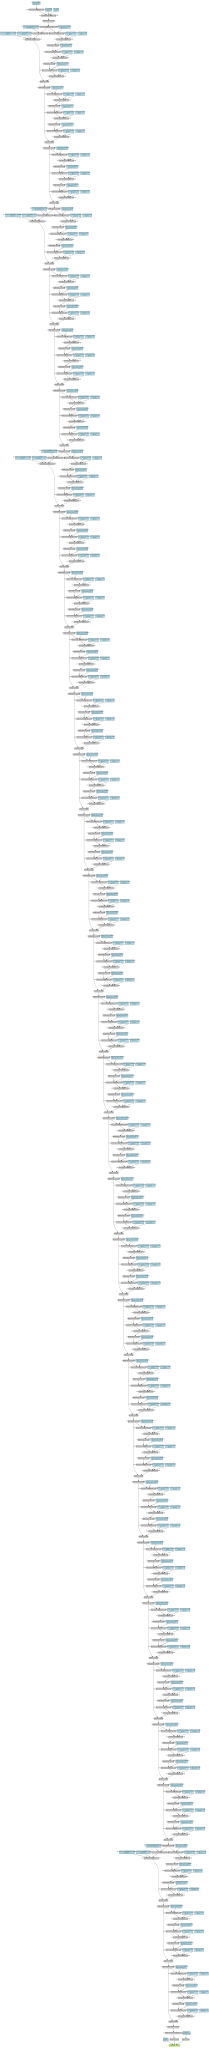

In [73]:
input_ = torch.rand(1, 3, 224, 224).to('cuda')
output = resnet101.to('cuda')(input_)
make_dot(output, dict(resnet101.named_parameters()))

In [74]:
resnet152 = ResNet(Bottleneck, [3, 8, 36, 3], 1000)
with torch.no_grad():
    resnet101.load_state_dict(model_zoo.load_url(model_urls['resnet101']))
summary(resnet101.to('cuda'), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

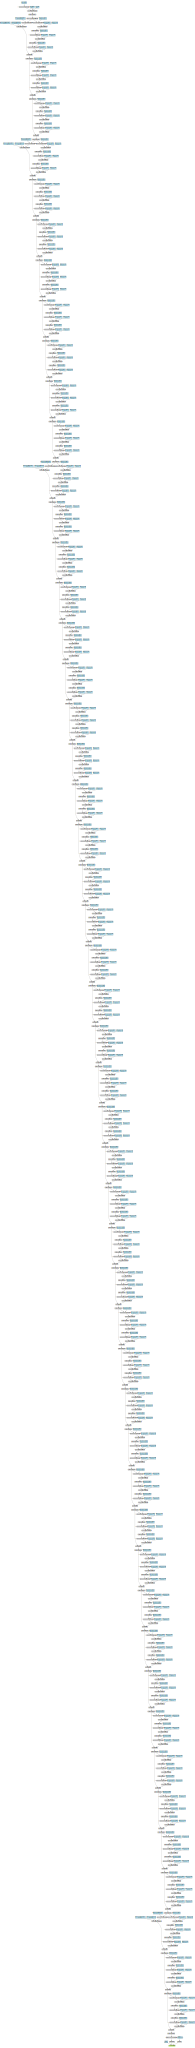

In [75]:
input_ = torch.rand(1, 3, 224, 224).to('cuda')
output = resnet152.to('cuda')(input_)
make_dot(output, dict(resnet152.named_parameters()))